# Toy model: 
<img src="OME_MetabolicNetwork.svg" width="800">

For the example in this notebook, we chose the values $s_1$ = 2, $s_X$ = 100, $s_3$ = 10.

Stoichiometric matrix (of internal metabolites):

$\mathbf{N} = \begin{pmatrix} 1 & -1 & 0 & 0 & 0 & 0 \\ 0 & 2 & -1 & -1 & 1 & -1 \\ 0 & 2 & 0 & 10 & 0 & -100 \\ 0 & -2 & 0 & -10 & 0 & 100 \end{pmatrix}$

Steady-state conditions:

$\begin{pmatrix} \dot{g} \\ \dot{p} \\ \dot{atp} \\ \dot{adp}\end{pmatrix} = \begin{pmatrix} 1 & -1 & 0 & 0 & 0 & 0 \\ 0 & 2 & -1 & -1 & 1 & -1 \\ 0 & 2 & 0 & 10 & 0 & -100 \\ 0 & -2 & 0 & -10 & 0 & 100 \end{pmatrix} \begin{pmatrix} v_0 \\ v_1 \\ v_2 \\ v_3 \\ v_4 \\ v_{BM} \end{pmatrix} = \begin{pmatrix} 0 \\ 0 \\ 0 \\ 0\end{pmatrix}$

In [1]:
import numpy as np
import pandas as pd
import sympy
import scipy.optimize
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams["text.usetex"] = True

In [2]:
linecolors = ["#e83041", "#3d23c2", "#13beff", "#ff9c00", "#938e96"]
efmcolors = ["#f5a3db", "#a3c6f5", "#f5cda3"]

In [3]:
S = sympy.Matrix([
    [1, -1, 0, 0, 0, 0], # g
    [0, 2, -1, -1, 1, -1], # p
    [0, 2, 0, 10, 0, -100], # atp
    [0, -2, 0, -10, 0, 100], # adp
])
e = sympy.symbols("E_0 E_1 E_2 E_3 E_4 E_{bm}")
v = sympy.symbols("v_0 v_1 v_2 v_3 v_4 v_{bm}")
kcat = sympy.symbols("k_{cat0} k_{cat1} k_{cat2} k_{cat3} k_{cat4} k_{catbm}")
deltag0 = sympy.symbols(r"ΔG^\circ_0 ΔG^\circ_1 ΔG^\circ_2 ΔG^\circ_3 ΔG^\circ_4 ΔG^\circ_{bm}")
c_g_e, c_co2_e, c_o2_e, c_p_e, c_bm_e = sympy.symbols("G_ext CO_2_ext O_2_ext P_ext BM_ext")
lnC = sympy.symbols("lnC_{G} lnC_{P} lnC_{ATP} lnC_{ADP}") # internal log concentrations
lnC_g, lnC_p, lnC_atp, lnC_adp = lnC
Km = sympy.symbols("K_{ge1} K_{g1} K_{adp1} K_{p1} K_{atp3} K_{pe1} K_{p2} K_{p3} K_{o3} "
                   "K_{adp3} K_{co3} K_{pe4} K_{p4} K_{xbm} K_{pbm} K_{atpbm} K_{adpbm}")
kge1, kg1, kadp1, kp1, katp3, kpe1, kp2, kp3, ko3, kadp3, kco3, kpe4, kp4, kxbm, kpbm, katpbm, kadpbm = Km

R = 8.3e-3
T = 293.
deltag = sympy.Matrix(deltag0) + S.T @ sympy.Matrix(lnC)
eta_thr = [1. - sympy.exp(dg/(R*T)) for dg in deltag]

In [4]:
c_p = sympy.exp(lnC_p)
c_g = sympy.exp(lnC_g)
c_atp = sympy.exp(lnC_atp)
c_adp = sympy.exp(lnC_adp)

eta_sat = [
    (c_g_e/kge1) / (1. + (c_g/kg1) + (c_g_e/kge1)),
    (c_g/kg1) * (c_adp/kadp1) / (1. + (c_p/kp1) * (c_p/kp1) * (c_atp/katp3) + (c_g/kg1) * (c_adp/kadp1) ),
    (c_p/kp2) / (1. + c_p_e/kpe1 + c_p/kp2),
    (c_p/kp3) * (c_o2_e/ko3) * (c_adp/kadp3) / (1. + (c_co2_e/kco3) * (c_atp/katp3) + (c_p/kp3) * (c_o2_e/ko3) * (c_adp/kadp3)),
    (c_p_e/kpe4) / (1. + c_p/kp4 + c_p_e/kpe4),
    (c_p/kpbm) * (c_atp/katpbm) / (1. + (c_bm_e/kxbm) * (c_adp/kadpbm) + (c_p/kpbm) * (c_atp/katpbm)),
]

rate_laws = [e[i] * kcat[i] * eta_sat[i] * eta_thr[i] for i in range(len(v))]
enzyme_demands = [v[i] / (kcat[i] * eta_sat[i] * eta_thr[i]) for i in range(len(v))]
e_tot = sum(enzyme_demands)

In [5]:
for _e, _d in zip(e, enzyme_demands):
    display(sympy.Equality(_e, _d))

Eq(E_0, K_{ge1}*v_0*(G_ext/K_{ge1} + 1.0 + exp(lnC_{G})/K_{g1})/(G_ext*k_{cat0}*(1.0 - exp(0.411201118467042*lnC_{G} + 0.411201118467042*ΔG^\circ_0))))

Eq(E_1, K_{adp1}*K_{g1}*v_1*(1.0 + exp(lnC_{ATP})*exp(2*lnC_{P})/(K_{atp3}*K_{p1}**2) + exp(lnC_{ADP})*exp(lnC_{G})/(K_{adp1}*K_{g1}))*exp(-lnC_{ADP})*exp(-lnC_{G})/(k_{cat1}*(1.0 - exp(-0.822402236934084*lnC_{ADP} + 0.822402236934084*lnC_{ATP} - 0.411201118467042*lnC_{G} + 0.822402236934084*lnC_{P} + 0.411201118467042*ΔG^\circ_1))))

Eq(E_2, K_{p2}*v_2*(1.0 + P_ext/K_{pe1} + exp(lnC_{P})/K_{p2})*exp(-lnC_{P})/(k_{cat2}*(1.0 - exp(-0.411201118467042*lnC_{P} + 0.411201118467042*ΔG^\circ_2))))

Eq(E_3, K_{adp3}*K_{o3}*K_{p3}*v_3*(CO_2_ext*exp(lnC_{ATP})/(K_{atp3}*K_{co3}) + 1.0 + O_2_ext*exp(lnC_{ADP})*exp(lnC_{P})/(K_{adp3}*K_{o3}*K_{p3}))*exp(-lnC_{ADP})*exp(-lnC_{P})/(O_2_ext*k_{cat3}*(1.0 - exp(-4.11201118467042*lnC_{ADP} + 4.11201118467042*lnC_{ATP} - 0.411201118467042*lnC_{P} + 0.411201118467042*ΔG^\circ_3))))

Eq(E_4, K_{pe4}*v_4*(1.0 + P_ext/K_{pe4} + exp(lnC_{P})/K_{p4})/(P_ext*k_{cat4}*(1.0 - exp(0.411201118467042*lnC_{P} + 0.411201118467042*ΔG^\circ_4))))

Eq(E_{bm}, K_{atpbm}*K_{pbm}*v_{bm}*(BM_ext*exp(lnC_{ADP})/(K_{adpbm}*K_{xbm}) + 1.0 + exp(lnC_{ATP})*exp(lnC_{P})/(K_{atpbm}*K_{pbm}))*exp(-lnC_{ATP})*exp(-lnC_{P})/(k_{catbm}*(1.0 - exp(41.1201118467042*lnC_{ADP} - 41.1201118467042*lnC_{ATP} - 0.411201118467042*lnC_{P} + 0.411201118467042*ΔG^\circ_{bm}))))

In [6]:
Km_params = {K: 1. for K in Km}     # set Km values all to 1
detlaG0_params = {g: -1000 for g in deltag0} # set all driving forces to practically infinity (1 million kJ/mol)
kcat_params = { # set the kcat values 
    kcat[0]: 10.,
    kcat[1]: 10.,
    kcat[2]: 10.,
    kcat[3]: 0.1,
    kcat[4]: 10.,
    kcat[5]: 10.,
}
external_concentration_params = {   # set the concentrations of external metabolites
    c_p_e: 1.,
    c_o2_e: .1,
    c_co2_e: 10.,
    c_bm_e: 1.,
    c_g_e: .05,
}
flux_params = { # set the flux ratios (all relative to v2) based on EFM 1 and EFM 2
    v[0] : 5. + 5. / 11. * v[2],
    v[1] : 5. + 5. / 11. * v[2],
    v[3] : 9. - 1. / 11. * v[2],
    v[4] : 0.,
    v[5] : 1.
}

global_params = dict()
global_params.update(kcat_params)
global_params.update(Km_params)
global_params.update(detlaG0_params)
global_params.update(external_concentration_params)
global_params.update(flux_params)

In [7]:
e_tot_paramed = e_tot.subs(global_params)

In [8]:
for _e, _d in zip(e, enzyme_demands):
    display(sympy.Equality(_e, _d.subs(global_params)))

Eq(E_0, 2.0*(0.454545454545455*v_2 + 5.0)*(1.0*exp(lnC_{G}) + 1.05)/(1.0 - 2.61591300714351e-179*exp(0.411201118467042*lnC_{G})))

Eq(E_1, 0.1*(0.454545454545455*v_2 + 5.0)*(1.0*exp(lnC_{ADP})*exp(lnC_{G}) + 1.0*exp(lnC_{ATP})*exp(2*lnC_{P}) + 1.0)*exp(-lnC_{ADP})*exp(-lnC_{G})/(1.0 - 2.61591300714351e-179*exp(-0.822402236934084*lnC_{ADP} + 0.822402236934084*lnC_{ATP} - 0.411201118467042*lnC_{G} + 0.822402236934084*lnC_{P})))

Eq(E_2, 0.1*v_2*(1.0*exp(lnC_{P}) + 2.0)*exp(-lnC_{P})/(1.0 - 2.61591300714351e-179*exp(-0.411201118467042*lnC_{P})))

Eq(E_3, 100.0*(9.0 - 0.0909090909090909*v_2)*(0.1*exp(lnC_{ADP})*exp(lnC_{P}) + 10.0*exp(lnC_{ATP}) + 1.0)*exp(-lnC_{ADP})*exp(-lnC_{P})/(1.0 - 2.61591300714351e-179*exp(-4.11201118467042*lnC_{ADP} + 4.11201118467042*lnC_{ATP} - 0.411201118467042*lnC_{P})))

Eq(E_4, 0)

Eq(E_{bm}, 0.1*(1.0*exp(lnC_{ADP}) + 1.0*exp(lnC_{ATP})*exp(lnC_{P}) + 1.0)*exp(-lnC_{ATP})*exp(-lnC_{P})/(1.0 - 2.61591300714351e-179*exp(41.1201118467042*lnC_{ADP} - 41.1201118467042*lnC_{ATP} - 0.411201118467042*lnC_{P})))

Text(0, 0.5, '$\\varepsilon_{tot}$')

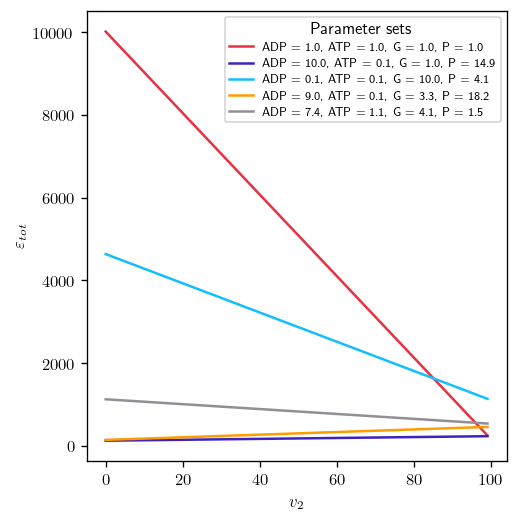

In [9]:
# plot the total enzyme cost for 5 select internal parameter sets
# showing how the cost scales linearly between two EFMs

internal_params = (
    { lnC_adp : 0.0, lnC_atp : 0.0, lnC_g : 0.0, lnC_p : 0.0 },
    { lnC_adp : 2.3, lnC_atp : -2.3, lnC_g : 0.0, lnC_p : 2.7 },
    { lnC_adp : -2.3, lnC_atp : -2.3, lnC_g : 2.3, lnC_p : 1.4 },
    { lnC_adp : 2.2, lnC_atp : -2.7, lnC_g : 1.2, lnC_p : 2.9 },
    { lnC_adp : 2.0, lnC_atp : 0.1, lnC_g : 1.4, lnC_p : 0.4 },
)
data = []
for i, p in enumerate(internal_params): # try the minimization starting at different initial conditions
    e_tot_p = e_tot_paramed.subs(p)
    for v2 in np.linspace(0, 99, 100):
        data.append((i, v2, e_tot_p.subs({v[2]: v2})))
data_df = pd.DataFrame(data=data, columns=["internal_param_set", "v2", "Etot"])


fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=120)
plt.subplots_adjust(wspace=1,hspace=0.5,left=0.2,top=0.9,right=0.9,bottom=0.15)
for i, (iparam_set, group_df) in enumerate(data_df.groupby("internal_param_set")):
    param_set = ", ".join([f"{str(met).replace('lnC_', '')} = {np.exp(x):.1f}" for met, x in internal_params[iparam_set].items()])
    ax.plot(group_df.v2, group_df.Etot, '-', label=param_set, color=linecolors[i])
ax.legend(title="Parameter sets", fontsize=7)
ax.set_xlabel("$v_2$")
ax.set_ylabel(r"$\varepsilon_{tot}$")

In [10]:
for v2 in [0.0, 99.0]:
    f = sympy.lambdify(lnC, e_tot_paramed.subs({v[2]: v2}))
    sol = scipy.optimize.minimize(
        lambda x: f(*x),
        x0=[1., 1., 1., 1.],
        bounds=[(-3, 3)]*4
    )
    print('-'*50)
    print(f"v[2] = {v2}")
    print(", ".join([f"[{met}] = {np.exp(x):.2f}" for met, x in zip(["G", "P", "ATP", "ADP"], sol.x)]))
    print(f"Etot = {sol.fun:.1f}")

--------------------------------------------------
v[2] = 0.0
[G] = 0.23, [P] = 20.09, [ATP] = 0.05, [ADP] = 20.09
Etot = 111.1
--------------------------------------------------
v[2] = 99.0
[G] = 0.08, [P] = 3.93, [ATP] = 0.11, [ADP] = 20.09
Etot = 146.3


In [11]:
# Show that the 3 EFMs are in the nullspace of S
efms = np.array([
    (5, 5, 0, 9, 0, 1),    # EFM 1
    (50, 50, 99, 0, 0, 1), # EFM 2
    (0, 0, 0, 10, 11, 1),  # EFM 3
])
display(S @ efms.T)

Matrix([
[0, 0, 0],
[0, 0, 0],
[0, 0, 0],
[0, 0, 0]])

In [12]:
# also check that the flux constraints in "flux_params" are always in the nullspace
display(S @ sympy.Matrix(v).subs(flux_params))

Matrix([
[                        0],
[-2.77555756156289e-17*v_2],
[-1.11022302462516e-16*v_2],
[ 1.11022302462516e-16*v_2]])

# Monod curve
plot the Monod curve for G in this model: solve the optimization problem for different values of `c_g_e`

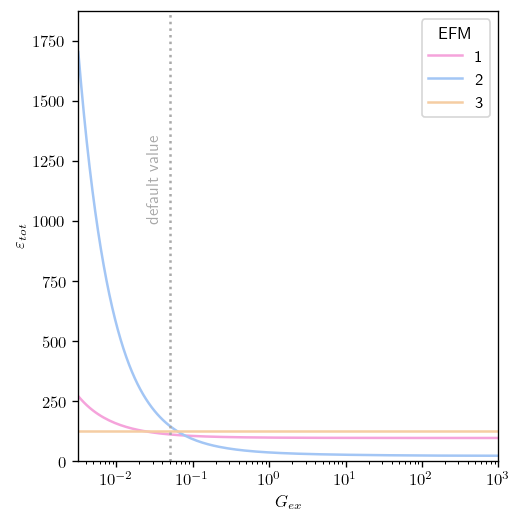

In [13]:
external_concentration_params_without_c_g_e = {   # set the concentrations of external metabolites
    c_p_e: 1.,
    c_o2_e: .1,
    c_co2_e: 10.,
    c_bm_e: 1.,
}
c_g_e_default = .05

global_params = dict()
global_params.update(kcat_params)
global_params.update(Km_params)
global_params.update(detlaG0_params)
global_params.update(external_concentration_params_without_c_g_e)
e_tot_paramed = e_tot.subs(global_params)

e_tot_efms = [
    e_tot_paramed.subs({v[i]: efms[i_efm, i] for i in range(efms.shape[1])})
    for i_efm in range(efms.shape[0])
]

data = []
for i, e_tot_efm in enumerate(e_tot_efms):
    for c in np.logspace(-2.5, 3, 150):
        lambda_e_tot = sympy.lambdify(lnC, e_tot_efm.subs({c_g_e: c}))
        sol = scipy.optimize.minimize(
            lambda x: lambda_e_tot(*x),
            x0=[0.]*4,
            bounds=[(-3, 3)]*4
        )
        data.append((c, i+1, sol.fun))
monod_df = pd.DataFrame(data=data, columns=["G_ext", "EFM", "E_tot"])

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=120)
plt.subplots_adjust(wspace=1,hspace=0.5,left=0.2,top=0.9,right=0.9,bottom=0.15)
monod_df.pivot(index="G_ext", columns="EFM", values="E_tot").plot(ax=ax, color=efmcolors)
ax.plot([c_g_e_default, c_g_e_default], [0, monod_df.E_tot.max()*1.1], ":", color="darkgrey")
ax.text(c_g_e_default/2, 1000, "default value", rotation=90, color="darkgrey")
ax.set_ylim(0, monod_df.E_tot.max()*1.1)
ax.set_xlim(monod_df.G_ext.min(), monod_df.G_ext.max())
ax.set_xscale(r"log")
ax.set_xlabel(r"$G_{ex}$")
ax.set_ylabel(r"$\varepsilon_{tot}$")
fig.savefig("../vector_graphics/OME_GraphDiscreteSwitch.svg")
fig.savefig("../images/OME_GraphDiscreteSwitch.pdf")

## Plot the Monod curve (growth rate as a function of external Glucose)

$$\mu = \frac{a ~ f_{\rm prot} ~ v_{\rm BM}}{\varepsilon_{\rm tot} + b f_{\rm prot} v_{\rm BM}}$$

$$f_{\rm prot} = 0.5$$

$$a = 0.27, b = 0.2 h$$

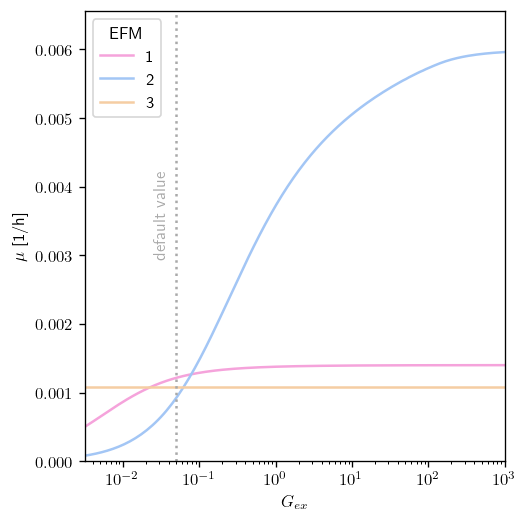

In [14]:
f_prot = 0.5 # fraction of protein mass withing the cell dry mass
a = 0.27 # unitless
b = 0.2 # h

v_BM = flux_params[v[5]]
monod_df["growth_rate"] = a * f_prot * v_BM / (monod_df["E_tot"] + b * f_prot * v_BM)

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=120)
plt.subplots_adjust(wspace=1,hspace=0.5,left=0.2,top=0.9,right=0.9,bottom=0.15)
monod_df.pivot(index="G_ext", columns="EFM", values="growth_rate").plot(ax=ax, color=efmcolors)
ax.plot([c_g_e_default, c_g_e_default], [0, monod_df.growth_rate.max()*1.1], ":", color="darkgrey")
ax.text(c_g_e_default/2, monod_df.growth_rate.max()*0.5, "default value", rotation=90, color="darkgrey")
ax.set_ylim(0, monod_df.growth_rate.max()*1.1)
ax.set_xlim(monod_df.G_ext.min(), monod_df.G_ext.max())
ax.set_xscale(r"log")
ax.set_xlabel(r"$G_{ex}$")
ax.set_ylabel(r"$\mu$ [1/h]")
fig.savefig("../vector_graphics/OME_GrowthRatesSwitch.svg")
fig.savefig("../images/OME_GrowthRatesSwitch.pdf")

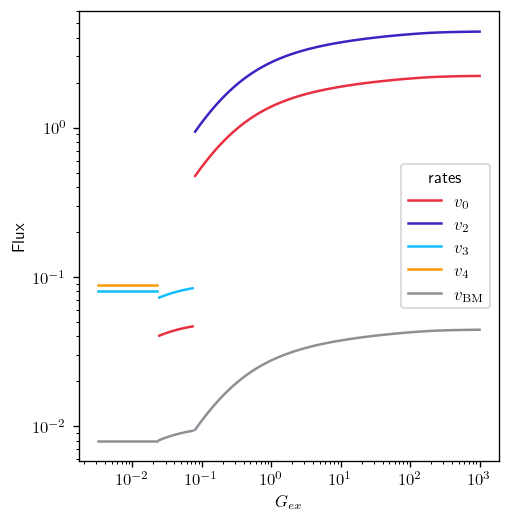

In [15]:
best_efm_df = monod_df.loc[monod_df.groupby('G_ext')["E_tot"].idxmin(), :]

efm_df = pd.DataFrame(data=efms, columns=[r'$v_0$', r'$v_1$', r'$v_2$', r'$v_3$', r'$v_4$', r'$v_{\rm BM}$'], dtype=float)
efm_df.index.name = "EFM"
efm_df.index += 1

best_efm_df = best_efm_df.join(efm_df, on="EFM")
for c in efm_df.columns:
    best_efm_df.loc[:, c] = best_efm_df.loc[:, c] / best_efm_df.E_tot

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=120)
plt.subplots_adjust(wspace=1, hspace=0.5, left=0.2, top=0.9, right=0.9, bottom=0.15)
ax.set_xscale("log")
ax.set_yscale("log")
for i_efm, group_df in best_efm_df.groupby("EFM"):
    group_df.plot("G_ext", y=[r'$v_0$', r'$v_2$', r'$v_3$', r'$v_4$', r'$v_{\rm BM}$'], ax=ax, color=linecolors)
ax.legend(title="rates", labels=[r'$v_0$', r'$v_2$', r'$v_3$', r'$v_4$', r'$v_{\rm BM}$'], loc="center right")
ax.set_ylabel("Flux")
ax.set_xlabel(r"$G_{ex}$")
fig.savefig("../vector_graphics/OME_MonodFluxes.svg")
fig.savefig("../images/OME_MonodFluxes.pdf")